# NUS GenAI Capstone Project

## Setup

In [1]:
# Import libraries

# === Core Python Libraries ===
import os
import replicate
import sqlite3
import requests
from IPython.display import Image, display, Markdown
from datetime import datetime, timedelta
from typing import TypedDict, Annotated, Optional

# === LangChain 1.0 - Agent Framework ===
from langchain.agents import create_agent
from langchain_core.tools import tool
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage, ToolMessage

# === LangGraph 1.0 - State Management & Checkpointing ===
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

# === Document Processing & Vector Storage ===
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma

# === Hybrid RAG - BM25 and Ensemble Retrievers ===
from langchain_community.retrievers import BM25Retriever
from langchain_classic.retrievers import EnsembleRetriever, ContextualCompressionRetriever

# === Reranking - Jina AI Cross-Encoder ===
from langchain_community.document_compressors import JinaRerank

In [3]:
# Retrieve API keys from environment variables
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")
REPLICATE_API_TOKEN = os.environ.get("REPLICATE_API_TOKEN")
WEATHER_API_KEY = os.environ.get("WEATHER_API_KEY")
JINA_API_KEY = os.environ.get("JINA_API_KEY")

In [4]:
# Prepare Hybrid RAG + rerank system for Singapore venue policies
# Load venue policy documents for Marina Bay Sands, Gardens by the Bay, Esplanade, and SG regulations

venue_policy_files = [
    'MBS-Event-Policy.pdf',
    'GBTB-Venue-Guide.pdf',
    'Esplanade-Manual.pdf',
    'SG-Event-Regulations.pdf'
]

# Load all venue policy documents
all_documents = []
for filepath in venue_policy_files:
    loader = PyMuPDFLoader(filepath)
    docs = loader.load()
    if docs:
        all_documents.extend(docs)
        print(f"✅ Loaded {len(docs)} pages from {filepath}")
    else:
        print(f"⚠️ No content extracted from {filepath}")

if not all_documents:
    raise ValueError("No documents loaded. Check PDF files.")

print(f"\n📄 Total pages loaded: {len(all_documents)}")

# Split into chunks optimized for policy documents
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = splitter.split_documents(all_documents)
if not chunks:
    raise ValueError("No chunks produced. Check document parsing.")
print(f"📋 Split into {len(chunks)} chunks (1000 char size, 200 overlap)")

# Create embeddings
embedding_model = OpenAIEmbeddings(api_key=OPENAI_API_KEY, model="text-embedding-3-small")
print("✅ Embedding model initialized")

# Create semantic retriever (dense vector search)
vector_store = Chroma.from_documents(
    documents=chunks,
    embedding=embedding_model,
    persist_directory="./venue_policies_chroma_db"
)
semantic_retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 5})
print("✅ Semantic retriever created (Chroma + OpenAI embeddings)")

# Create BM25 retriever (keyword/sparse search)
bm25_retriever = BM25Retriever.from_documents(chunks)
bm25_retriever.k = 5
print("✅ BM25 retriever created (keyword-based)")

# Combine retrievers with Reciprocal Rank Fusion (RRF)
hybrid_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, semantic_retriever],
    weights=[0.4, 0.6]  # 40% keyword (BM25), 60% semantic
)
print("✅ Hybrid retriever created (BM25 + Semantic with RRF)")
print("   Weights: 40% keyword, 60% semantic")

# Add Jina AI reranker on top of hybrid retrieval (3-stage retrieval)
compressor = JinaRerank(
    model="jina-reranker-v2-base-multilingual",  # Jina Reranker v2 (v3 may not be in API yet)
    top_n=3,  # Return top 3 after reranking
    jina_api_key=JINA_API_KEY
)

reranking_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=hybrid_retriever
)
print("✅ Reranking retriever created (Jina Reranker v2)")
print("🎯 RAG system ready")

✅ Loaded 8 pages from MBS-Event-Policy.pdf
✅ Loaded 8 pages from GBTB-Venue-Guide.pdf
✅ Loaded 17 pages from Esplanade-Manual.pdf
✅ Loaded 18 pages from SG-Event-Regulations.pdf

📄 Total pages loaded: 51
📋 Split into 115 chunks (1000 char size, 200 overlap)
✅ Embedding model initialized
✅ Semantic retriever created (Chroma + OpenAI embeddings)
✅ BM25 retriever created (keyword-based)
✅ Hybrid retriever created (BM25 + Semantic with RRF)
   Weights: 40% keyword, 60% semantic
✅ Reranking retriever created (Jina Reranker v2)
   3-stage pipeline: BM25 → Semantic → Jina cross-encoder rerank

🎯 Complete retrieval system ready:
   Stage 1: BM25 keyword search (exact matches)
   Stage 2: Semantic vector search (conceptual)
   Stage 3: Jina AI cross-encoder reranking (relevance)

✨ Optimized for venue policy queries with proper nouns, codes, and concepts!


In [5]:
# Create enhanced Singapore-focused events database
def setup_database():
    """Initialize the events database with Singapore-focused event planning data."""
    conn = sqlite3.connect('events.db')
    c = conn.cursor()

    # Drop old table if exists (migration)
    c.execute('DROP TABLE IF EXISTS events')
    
    # Create enhanced table schema
    c.execute('''
        CREATE TABLE events (
            id INTEGER PRIMARY KEY,
            name TEXT NOT NULL,
            category TEXT,
            type TEXT,
            description TEXT,
            
            venue_name TEXT NOT NULL,
            location_address TEXT,
            postal_code TEXT,
            mrt_station TEXT,
            
            date TEXT NOT NULL,
            start_time TEXT,
            end_time TEXT,
            duration_hours REAL,
            
            expected_capacity INTEGER,
            ticket_price TEXT,
            equipment_needs TEXT,
            
            requires_permit INTEGER DEFAULT 0,
            requires_insurance INTEGER DEFAULT 0,
            sound_level_limit TEXT,
            
            wheelchair_accessible INTEGER DEFAULT 1,
            has_assisted_listening INTEGER DEFAULT 0,
            
            weather_dependent INTEGER DEFAULT 0,
            rain_backup_plan TEXT,
            
            organizer TEXT,
            contact_email TEXT,
            booking_url TEXT,
            notes TEXT
        )
    ''')

    today = datetime.now().date()
    def iso(days=0): return (today + timedelta(days=days)).isoformat()

    # Singapore-focused event data with event planning details
    events = [
        # === TODAY (6 events) ===
        # Marina Bay Sands events
        ("Marina Bay Sands Grand Concert", "music", "indoor", 
         "Symphony orchestra performing classical masterpieces in the Grand Ballroom",
         "Marina Bay Sands", "10 Bayfront Ave", "018956", "Bayfront (CE1/DT16)",
         iso(0), "19:30", "22:30", 3.0,
         2000, "$100-$300", "professional_lighting,sound_system,stage,formal_seating",
         1, 1, "No specific limit (indoor venue)",
         1, 1,
         0, None,
         "MBS Events Team", "events@marinabaysands.com", "https://marinabaysands.com/events",
         "Black tie optional. Professional photography allowed but NO tripods per MBS policy. Drone photography strictly prohibited."),
        
        ("MBS Tech Innovation Summit", "tech", "indoor",
         "Startup pitches and product demonstrations in Convention Centre",
         "Marina Bay Sands", "10 Bayfront Ave", "018956", "Bayfront (CE1/DT16)",
         iso(0), "09:00", "18:00", 9.0,
         3000, "$50-$200", "projectors,microphones,stage,exhibition_booths",
         1, 1, "No specific limit (indoor venue)",
         1, 1,
         0, None,
         "TechSG", "contact@techsg.org", "https://techsg.org/summit",
         "Business casual attire. Equipment setup requires prior approval from MBS events team."),
        
        # Gardens by the Bay events  
        ("Gardens by the Bay Food Festival", "food", "outdoor",
         "Outdoor food carnival featuring local and international cuisine",
         "Gardens by the Bay", "18 Marina Gardens Dr", "018953", "Bayfront (CE1/DT16)",
         iso(0), "11:00", "21:00", 10.0,
         5000, "Free entry", "tents,food_stalls,tables,waste_management,amplified_sound",
         1, 1, "85dBA daytime (9am-6pm), 80dBA evening (6pm-10pm)",
         1, 0,
         1, "Move food stalls to covered Garden Pavilion. Event will proceed with modifications.",
         "GBTB Events", "events@gardensbythebay.com.sg", "https://gardensbythebay.com.sg/food-festival",
         "Sound level restrictions strictly enforced per GBTB policy. No amplified music between 10pm-9am. Background music max 65-70dBA."),
        
        # Esplanade events
        ("Esplanade Contemporary Art Exhibition", "art", "indoor",
         "Modern art showcase in the Concourse Gallery",
         "Esplanade", "1 Esplanade Dr", "038981", "Esplanade (CC3)",
         iso(0), "10:00", "20:00", 10.0,
         800, "Free", "gallery_lighting,display_stands,security",
         1, 0, "No specific limit (indoor venue)",
         1, 0,
         0, None,
         "Esplanade Co", "info@esplanade.com", "https://esplanade.com/exhibitions",
         "Photography allowed without flash. Wheelchair accessible via direct MRT connection. Companion seating available."),
        
        # Singapore Botanic Gardens
        ("Botanic Gardens Photography Workshop", "art", "outdoor",
         "Learn nature photography with professional guidance",
         "Singapore Botanic Gardens", "1 Cluny Rd", "259569", "Botanic Gardens (CC19/DT9)",
         iso(0), "09:00", "12:00", 3.0,
         25, "$150", "tripods_allowed,cameras,photography_equipment",
         1, 1, "Quiet environment required",
         1, 0,
         1, "Reschedule to next available weekend. Full refunds provided.",
         "SG Photo Society", "workshops@sgphoto.org", "https://sgphoto.org/workshops",
         "Tripods allowed for this workshop. No flash photography near sensitive plants. Small group size for personalized instruction."),
        
        # Other Singapore venue
        ("Sentosa Beach Yoga Session", "sports", "outdoor",
         "Morning yoga and meditation on Siloso Beach",
         "Siloso Beach Sentosa", "51 Imbiah Walk", "099538", "HarbourFront (NE1/CC29)",
         iso(0), "07:00", "08:30", 1.5,
         50, "$30", "yoga_mats,portable_speaker,shade_tent",
         1, 1, "Ambient sound only (no amplification needed)",
         1, 0,
         1, "Move to covered pavilion nearby. Event proceeds unless heavy rain.",
         "Sentosa Wellness", "wellness@sentosa.com.sg", "https://sentosa.com.sg/wellness",
         "Bring your own mat or rent on-site. Suitable for all fitness levels. Weather-dependent outdoor activity."),
    ]

    # Insert data
    c.executemany('''
        INSERT INTO events (
            name, category, type, description,
            venue_name, location_address, postal_code, mrt_station,
            date, start_time, end_time, duration_hours,
            expected_capacity, ticket_price, equipment_needs,
            requires_permit, requires_insurance, sound_level_limit,
            wheelchair_accessible, has_assisted_listening,
            weather_dependent, rain_backup_plan,
            organizer, contact_email, booking_url, notes
        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    ''', events)

    conn.commit()
    print(f"✅ Database setup completed successfully!")    
    conn.close()

# Run setup
setup_database()

✅ Database setup completed successfully!


## Implementation

In [6]:
@tool
def retrieve_venue_policies(query: str) -> str:
    """
    Retrieve venue policies, restrictions, and requirements from Singapore event venues.
    Uses 3-stage retrieval: BM25 + semantic + Jina Reranker v2 for maximum relevance.
    
    Covers:
    - Photography/equipment restrictions (tripods, drones, professional gear)
    - Sound level limits and amplified music regulations  
    - Capacity limits and safety requirements
    - Accessibility features (wheelchair access, assisted listening)
    - Insurance requirements and liability coverage
    - MRT access, postal codes, and parking information
    - Technical specifications (stage dimensions, lighting, sound systems)
    
    Args:
        query: Question about venue policies (e.g., "tripod policy at Marina Bay Sands")
    
    Returns:
        Relevant policy excerpts with source attribution (venue name and page number)
    """
    # Use reranking retriever for best results
    retrieved_docs = reranking_retriever.invoke(query)
    
    # Format with source attribution for transparency
    formatted = []
    for doc in retrieved_docs:
        source = doc.metadata.get('source', 'Unknown')
        page = doc.metadata.get('page', '?')
        # Extract just the filename without path
        source_name = source.split('\\')[-1].split('/')[-1].replace('.pdf', '')
        formatted.append(f"[{source_name}, p.{page}]\n{doc.page_content}\n")
    
    return "\n".join(formatted)

# Store pending image requests for approval
pending_image_requests = {}

@tool
def request_image_generation(prompt: str, seed: int = 42, steps: int = 30) -> str:
    """
    Request to generate an image using Replicate API.
    This will ask for user approval before actually generating the image (costs money).
    
    Args:
        prompt: Description of the image to generate
        seed: Random seed for reproducibility (default: 42)
        steps: Number of generation steps (default: 30)
    
    Returns:
        A message indicating approval is needed
    """
    import uuid
    request_id = str(uuid.uuid4())
    pending_image_requests[request_id] = {
        "prompt": prompt,
        "seed": seed,
        "steps": steps
    }
    return f"🖼️ Image generation requested for: '{prompt}'\n\n⚠️ This will cost money via Replicate API. Please approve by calling 'approve_image_generation' with request_id: {request_id}"

@tool
def approve_image_generation(request_id: str) -> str:
    """
    Approve and execute a pending image generation request.
    
    Args:
        request_id: The ID of the pending image request to approve
    
    Returns:
        URL of the generated image or error message
    """
    if request_id not in pending_image_requests:
        return "⚠️ Invalid or expired request ID. No pending image generation found."
    
    request = pending_image_requests.pop(request_id)
    prompt = request["prompt"]
    seed = request["seed"]
    steps = request["steps"]
    
    try:
        output = replicate.run(
            "stability-ai/stable-diffusion-3.5-medium",
            input={"prompt": prompt, "seed": seed, "steps": steps}
        )

        # Handle unexpected response formats
        if isinstance(output, list):
            return output[0] if output else "⚠️ No image generated."
        elif hasattr(output, "url"):
            return output.url
        else:
            return str(output)
    except replicate.exceptions.ModelError as e:
        return f"⚠️ Image generation model error: {e}"
    except replicate.exceptions.ReplicateError as e:
        return f"⚠️ Replicate API error: {e}"
    except Exception as e:
        return f"⚠️ Unexpected image generation error: {e}"

@tool
def get_current_date() -> str:
    """
    Returns today's date in ISO format (YYYY-MM-DD).
    Use this tool when you need to know the current date for querying events or making date-based recommendations.
    """
    return datetime.now().date().isoformat()

In [7]:
@tool
def get_weather(location: str = 'Singapore') -> str:
    """
    Retrieve real-time weather data via the WeatherAPI.
    Takes a location as input and returns weather information including temperature and conditions.
    """
    url = "http://api.weatherapi.com/v1/current.json"
    params = {"key": WEATHER_API_KEY, "q": location, "aqi": "no"}
    try:
        response = requests.get(url, params=params, timeout=10)
        response.raise_for_status()
        data = response.json()
        
        # Extract relevant weather information
        location_name = data['location']['name']
        country = data['location']['country']
        temp_c = data['current']['temp_c']
        condition = data['current']['condition']['text']
        
        return f"Weather in {location_name}, {country}: {temp_c}°C, {condition}"
    except requests.exceptions.Timeout:
        return f"⚠️ Weather API request timed out for {location}."
    except requests.exceptions.ConnectionError:
        return f"⚠️ Network connection failed while fetching weather for {location}."
    except requests.exceptions.HTTPError as e:
        return f"⚠️ Weather API HTTP error: {e}"
    except KeyError:
        return f"⚠️ Unexpected weather data format for {location}."
    except Exception as e:
        return f"⚠️ Unexpected weather retrieval error: {e}"

In [8]:
@tool
def get_events(date: str, event_type: str | None = None, category: str | None = None, venue_name: str | None = None) -> str:
    """
    Retrieves Singapore event data by querying the enhanced events database.
    All events are in Singapore with detailed event planning information.
    
    Args:
        date: Event date in YYYY-MM-DD format
        event_type: Optional filter by type ('indoor', 'outdoor', 'hybrid')
        category: Optional filter by category ('music', 'food', 'art', 'tech', 'cultural', 'sports')
        venue_name: Optional filter by venue (e.g., 'Marina Bay Sands', 'Esplanade', 'Gardens by the Bay')
    
    Returns:
        Formatted string with event details including venue, timing, accessibility, weather impact, and booking info
    """
    conn = sqlite3.connect('events.db')
    c = conn.cursor()
    
    # Build query dynamically based on filters
    query = 'SELECT * FROM events WHERE date=?'
    params = [date]
    
    if event_type:
        query += ' AND type=?'
        params.append(event_type)
    
    if category:
        query += ' AND category=?'
        params.append(category)
        
    if venue_name:
        query += ' AND venue_name LIKE ?'
        params.append(f'%{venue_name}%')
    
    c.execute(query, params)
    events = c.fetchall()
    conn.close()
    
    if not events:
        filter_desc = f" on {date}"
        if event_type:
            filter_desc += f", type={event_type}"
        if category:
            filter_desc += f", category={category}"
        if venue_name:
            filter_desc += f", venue={venue_name}"
        return f"No events found in Singapore{filter_desc}"
    
    # Format events with enhanced details
    formatted_events = []
    for event in events:
        (event_id, name, cat, etype, desc,
         venue, addr, postal, mrt,
         edate, start_time, end_time, duration,
         capacity, price, equipment,
         req_permit, req_insurance, sound_limit,
         wheelchair, assisted_listening,
         weather_dep, rain_backup,
         organizer, email, url, notes) = event
        
        # Build comprehensive event description
        event_str = f"📅 **{name}** ({cat}, {etype})\n"
        event_str += f"   📍 Venue: {venue} @ {addr} ({postal})\n"
        event_str += f"   🚇 MRT: {mrt}\n"
        event_str += f"   ⏰ Time: {start_time} - {end_time} ({duration}h)\n"
        event_str += f"   💰 Price: {price}\n"
        event_str += f"   👥 Capacity: {capacity}\n"
        
        # Event planning details
        if equipment:
            event_str += f"   🎬 Equipment: {equipment}\n"
        if req_permit or req_insurance:
            reqs = []
            if req_permit:
                reqs.append("permit")
            if req_insurance:
                reqs.append("insurance")
            event_str += f"   📋 Requirements: {', '.join(reqs)}\n"
        if sound_limit:
            event_str += f"   🔊 Sound limit: {sound_limit}\n"
        
        # Accessibility
        access_features = []
        if wheelchair:
            access_features.append("wheelchair accessible")
        if assisted_listening:
            access_features.append("assisted listening")
        if access_features:
            event_str += f"   ♿ Accessibility: {', '.join(access_features)}\n"
        
        # Weather impact
        if weather_dep and rain_backup:
            event_str += f"   🌧️  Weather-dependent. Rain plan: {rain_backup}\n"
        elif weather_dep:
            event_str += f"   🌧️  Weather-dependent event (outdoor)\n"
        
        # Contact & booking
        event_str += f"   📧 Organizer: {organizer} ({email})\n"
        if url:
            event_str += f"   🔗 Booking: {url}\n"
        if notes:
            event_str += f"   ℹ️  Notes: {notes}\n"
        
        formatted_events.append(event_str)
    
    return "\n\n".join(formatted_events)

In [9]:
# Recommendation Tool - Simple LLM Chain

# Create prompt template for recommendations
recommendation_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a helpful event recommender. Consider the weather conditions and suggest suitable events. 
    For outdoor events, consider the temperature and weather conditions. Be specific about why you recommend certain events over others. 
    Keep your response concise but informative. 
    If event data is unavailable, politely request the user for additional event-related information.
    If weather data is unavailable, provide a balanced mix of indoor and outdoor suggestions."""),
    ("user", "{weather_and_event_data}")
])

# Create a simple chain: prompt → LLM
recommendation_chain = recommendation_prompt | ChatOpenAI(model="gpt-4o", api_key=OPENAI_API_KEY)

@tool
def recommend_events(weather_and_event_data: str) -> str:
    """
    Synthesize weather and event data into context-aware event recommendations.
    Takes combined weather and event information as input and returns personalized suggestions.
    
    Args:
        weather_and_event_data: Combined string containing weather conditions and available events
    
    Returns:
        A concise, personalized recommendation based on weather and events
    """
    try:
        # Invoke the chain with the input data
        result = recommendation_chain.invoke({"weather_and_event_data": weather_and_event_data})
        return result.content
    except Exception as e:
        return f"⚠️ Recommendation failed: {e}"

### LangGraph State Schemas

In [10]:
# State Schemas for LangGraph

# 1. Recommendation State - for parallel weather + events workflow
class RecommendationState(TypedDict):
    """State for event recommendation workflow with parallel execution."""
    messages: Annotated[list[BaseMessage], add_messages]
    current_date: str
    location: str
    event_type: Optional[str]
    weather_data: str
    event_data: str
    recommendations: str

# 2. Main Agent State - for overall conversation flow
class MainAgentState(TypedDict):
    """Main agent state with conversation history."""
    messages: Annotated[list[BaseMessage], add_messages]

# 3. Image Generation State - replaces global pending_image_requests dict
class ImageRequestState(TypedDict):
    """State for managing image generation requests with approval workflow."""
    messages: Annotated[list[BaseMessage], add_messages]
    request_id: str
    prompt: str
    seed: int
    steps: int
    status: str  # "pending", "approved", "completed", "rejected"
    image_url: Optional[str]

print("✅ State schemas defined for LangGraph")

✅ State schemas defined for LangGraph
⚠️  UPDATED: Removed 'country' field from RecommendationState (no longer in DB schema)


### Recommendation Subgraph - Parallel Execution

In [11]:
# Recommendation Subgraph Nodes - Explicit workflow with parallel execution

def get_date_node(state: RecommendationState) -> dict:
    """Node 1: Get current date."""
    current_date = datetime.now().date().isoformat()
    print(f"📅 Date retrieved: {current_date}")
    return {"current_date": current_date}

def get_weather_node(state: RecommendationState) -> dict:
    """Node 2: Fetch weather data (runs in parallel with get_events_node)."""
    location = state.get("location", "Singapore")
    
    url = "http://api.weatherapi.com/v1/current.json"
    params = {"key": WEATHER_API_KEY, "q": location, "aqi": "no"}
    
    try:
        response = requests.get(url, params=params, timeout=10)
        response.raise_for_status()
        data = response.json()
        
        location_name = data['location']['name']
        country = data['location']['country']
        temp_c = data['current']['temp_c']
        condition = data['current']['condition']['text']
        
        weather_data = f"Weather in {location_name}, {country}: {temp_c}°C, {condition}"
        print(f"🌤️  Weather fetched: {weather_data}")
        return {"weather_data": weather_data}
    
    except Exception as e:
        weather_data = f"⚠️ Weather unavailable for {location}: {e}"
        print(weather_data)
        return {"weather_data": weather_data}

def get_events_node(state: RecommendationState) -> dict:
    """Node 3: Query events from database (runs in parallel with get_weather_node)."""
    date = state["current_date"]
    event_type = state.get("event_type")
    
    conn = sqlite3.connect('events.db')
    c = conn.cursor()
    
    # Build query without country filter (all events are Singapore)
    query = 'SELECT * FROM events WHERE date=?'
    params = [date]
    
    if event_type:
        query += ' AND type=?'
        params.append(event_type)
    
    c.execute(query, params)
    events = c.fetchall()
    conn.close()
    
    if not events:
        event_data = f"No events found on {date}"
        if event_type:
            event_data += f" (type={event_type})"
        print(f"📋 {event_data}")
        return {"event_data": event_data}
    
    # Format events with minimal fields (name, category, type, venue, date, time)
    formatted_events = []
    for event in events:
        # Unpack all 27 fields from new schema
        (event_id, name, cat, etype, desc,
         venue, addr, postal, mrt,
         edate, start_time, end_time, duration,
         capacity, price, equipment,
         req_permit, req_insurance, sound_limit,
         wheelchair, assisted_listening,
         weather_dep, rain_backup,
         organizer, email, url, notes) = event
        
        # Minimal formatting as requested
        formatted_events.append(
            f"- {name} ({cat}, {etype}): {desc}. Venue: {venue}. Time: {start_time}-{end_time}"
        )
    
    event_data = "\n".join(formatted_events)
    print(f"📋 Events retrieved: {len(events)} events found")
    return {"event_data": event_data}

def synthesize_recommendations_node(state: RecommendationState) -> dict:
    """Node 4: Synthesize weather + events into recommendations (replaces recommend_events tool)."""
    weather_data = state.get("weather_data", "Weather data unavailable")
    event_data = state.get("event_data", "Event data unavailable")
    
    # Combine data for LLM synthesis
    combined_data = f"""**Weather Information:**
{weather_data}

**Available Events:**
{event_data}"""
    
    # Use the existing recommendation chain
    try:
        result = recommendation_chain.invoke({"weather_and_event_data": combined_data})
        recommendations = result.content
        print(f"✅ Recommendations synthesized")
        
        # Add as AI message
        return {
            "recommendations": recommendations,
            "messages": [AIMessage(content=recommendations)]
        }
    except Exception as e:
        error_msg = f"⚠️ Recommendation synthesis failed: {e}"
        print(error_msg)
        return {
            "recommendations": error_msg,
            "messages": [AIMessage(content=error_msg)]
        }

print("✅ Recommendation subgraph nodes defined")

✅ Recommendation subgraph nodes defined
⚠️  UPDATED: get_events_node now queries without 'country' column and uses 27-field schema


In [12]:
# Build and Compile Recommendation Subgraph

# Create the graph
recommendation_graph = StateGraph(RecommendationState)

# Add nodes
recommendation_graph.add_node("get_date", get_date_node)
recommendation_graph.add_node("get_weather", get_weather_node)
recommendation_graph.add_node("get_events", get_events_node)
recommendation_graph.add_node("synthesize", synthesize_recommendations_node)

# Add edges for parallel execution
# START -> get_date
recommendation_graph.add_edge(START, "get_date")

# get_date -> BOTH get_weather AND get_events (parallel execution!)
recommendation_graph.add_edge("get_date", "get_weather")
recommendation_graph.add_edge("get_date", "get_events")

# BOTH get_weather AND get_events -> synthesize (waits for both to complete)
recommendation_graph.add_edge("get_weather", "synthesize")
recommendation_graph.add_edge("get_events", "synthesize")

# synthesize -> END
recommendation_graph.add_edge("synthesize", END)

# Compile the graph with checkpointer
recommendation_checkpointer = MemorySaver()
compiled_recommendation_graph = recommendation_graph.compile(
    checkpointer=recommendation_checkpointer
)

print("✅ Recommendation subgraph compiled successfully")
print("📊 Graph structure:")
print("   START → get_date")
print("   get_date → get_weather (parallel)")
print("   get_date → get_events (parallel)")
print("   [get_weather + get_events] → synthesize")
print("   synthesize → END")
print("\\n🚀 Parallel execution enabled: weather + events fetch concurrently!")

✅ Recommendation subgraph compiled successfully
📊 Graph structure:
   START → get_date
   get_date → get_weather (parallel)
   get_date → get_events (parallel)
   [get_weather + get_events] → synthesize
   synthesize → END
\n🚀 Parallel execution enabled: weather + events fetch concurrently!


In [13]:
# OLD Agent Setup - LangChain 1.0 (kept for comparison)

# Define tools available to main agent
tools = [
    retrieve_venue_policies,
    request_image_generation,
    approve_image_generation,
    get_current_date,
    get_weather,
    get_events,
    recommend_events
]

# Initialize LLM
llm = ChatOpenAI(model="gpt-4o", api_key=OPENAI_API_KEY)

# Create checkpointer for conversation persistence
checkpointer = MemorySaver()

### NEW LangGraph Agent - Explicit State Graph

In [ ]:
# NEW LangGraph Agent - Main Graph Nodes

def router_node(state: MainAgentState) -> dict:
    """
    Router node: Analyzes user intent and decides routing.
    Routes to: recommendation_subgraph, tool_node, or direct_response
    """
    last_message = state["messages"][-1]
    user_input = last_message.content.lower()
    
    # Create prompt for intent classification
    router_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are an intent classifier for an event planning assistant.
Analyze the user's message and classify it into ONE of these categories:

1. **recommendation** - User wants event recommendations based on weather/date
   Examples: "recommend events", "what should I do today", "events happening now"

2. **venue_policy** - User asks about venue policies, restrictions, accessibility
   Examples: "Can I bring tripods to MBS?", "sound restrictions at GBTB", "wheelchair access"

3. **image_generation** - User wants to generate or visualize images
   Examples: "generate image of", "show me a picture", "create visualization"

4. **general** - General questions, greetings, or other queries
   Examples: "hello", "what can you do", "tell me about yourself"

Respond with ONLY the category name (recommendation/venue_policy/image_generation/general)."""),
        ("user", "{input}")
    ])
    
    router_chain = router_prompt | llm
    result = router_chain.invoke({"input": user_input})
    intent = result.content.strip().lower()
    
    print(f"🧭 Router: Classified intent as '{intent}'")
    
    # Add routing decision to messages
    return {"messages": [AIMessage(content=f"[Intent: {intent}]", name="router")]}

def should_route_to_recommendation(state: MainAgentState) -> str:
    """Conditional edge function: Check if we should route to recommendation."""
    messages = state["messages"]
    # Look for router's classification
    for msg in reversed(messages):
        if isinstance(msg, AIMessage) and msg.name == "router":
            if "recommendation" in msg.content.lower():
                return "recommendation"
            elif "venue_policy" in msg.content.lower():
                return "tool"
            elif "image" in msg.content.lower():
                return "tool"
    return "general"

def tool_execution_node(state: MainAgentState) -> dict:
    """
    Execute individual tools for single-purpose queries.
    
    ARCHITECTURE NOTE: This uses a simplified single-shot tool execution pattern
    rather than the full agent loop pattern recommended in LangGraph documentation.
    
    Architectural Differences from LangGraph Docs:
    - Single-shot execution (call tools once, return results)
    - Manual tool execution loop (instead of using ToolNode from langgraph.prebuilt)
    - No multi-turn agent loop (agent → tools → agent → tools → ...)
    
    Trade-offs:
    ✓ Simpler and more predictable for independent tool queries
    ✓ Faster execution for single-tool scenarios
    ✗ Cannot do multi-step reasoning or error recovery
    ✗ Cannot iterate if first tool call doesn't satisfy query
    
    Acceptable for this use case because:
    - Venue policy queries are single-purpose (one tool, one answer)
    - Image generation is single-purpose (request or approve)
    - Recommendation workflow (which needs multi-step) is handled by separate subgraph
    
    For production at scale, consider:
    - Using langchain.agents.create_agent for automatic agent loop
    - Or implementing full agent ⇄ tools loop with conditional edges
    """
    messages = state["messages"]
    
    # Get the user query (skip router messages)
    user_query = None
    for msg in reversed(messages):
        if isinstance(msg, HumanMessage):
            user_query = msg.content
            break
    
    if not user_query:
        return {"messages": [AIMessage(content="No user query found.")]}
    
    # Tool scoping: Only bind tools relevant for discrete queries
    # Excludes recommendation tools (get_weather, get_events, recommend_events)
    # which are handled by the recommendation subgraph's hardcoded workflow
    tool_only_tools = [
        retrieve_venue_policies,       # Venue policy queries
        request_image_generation,      # Image generation request
        approve_image_generation       # Image generation approval
    ]
    
    # Bind tools to LLM
    llm_with_tools = llm.bind_tools(tool_only_tools)
    
    # Invoke LLM with full conversation history for context
    response = llm_with_tools.invoke(state["messages"])
    
    # Check if tools were called
    if response.tool_calls:
        # Add the AI response with tool calls to message history
        messages_to_return = [response]
        
        # Execute tools and create proper ToolMessages
        for tool_call in response.tool_calls:
            tool_name = tool_call["name"]
            tool_args = tool_call["args"]
            tool_call_id = tool_call["id"]  # Required for ToolMessage protocol
            
            print(f"🔧 Executing tool: {tool_name}")
            
            # Find and execute the tool with error handling
            for tool in tool_only_tools:
                if tool.name == tool_name:
                    try:
                        result = tool.invoke(tool_args)
                        # Create proper ToolMessage with tool_call_id
                        messages_to_return.append(
                            ToolMessage(
                                content=str(result),
                                tool_call_id=tool_call_id,
                                name=tool_name
                            )
                        )
                    except Exception as e:
                        # Handle errors gracefully - add error as ToolMessage
                        print(f"⚠️ Error executing {tool_name}: {e}")
                        messages_to_return.append(
                            ToolMessage(
                                content=f"⚠️ Error executing {tool_name}: {str(e)}",
                                tool_call_id=tool_call_id,
                                name=tool_name
                            )
                        )
                    break
        
        # CRITICAL: Let LLM synthesize final response based on tool results
        # Without this, user gets raw tool output instead of natural language
        final_response = llm.invoke(state["messages"] + messages_to_return)
        messages_to_return.append(final_response)
        
        return {"messages": messages_to_return}
    else:
        # No tools needed, return direct response
        return {"messages": [response]}

def recommendation_router_node(state: MainAgentState) -> dict:
    """
    Route to recommendation subgraph.
    Uses LLM to extract event_type from user message for better accuracy.
    """
    messages = state["messages"]
    
    # Get user query
    user_query = None
    for msg in reversed(messages):
        if isinstance(msg, HumanMessage):
            user_query = msg.content
            break
    
    # Use LLM for structured parameter extraction
    extraction_prompt = ChatPromptTemplate.from_messages([
        ("system", """Extract event search parameter from the user query.
Return JSON with this field (null if not mentioned):
- event_type: "indoor", "outdoor", "hybrid", or null

Examples:
"outdoor music events" -> {{"event_type": "outdoor"}}
"recommend events for today" -> {{"event_type": null}}
"indoor activities" -> {{"event_type": "indoor"}}
"hybrid events" -> {{"event_type": "hybrid"}}

Respond with ONLY valid JSON."""),
        ("user", "{query}")
    ])
    
    # Use structured output for reliable JSON parsing
    from pydantic import BaseModel, Field
    from typing import Optional
    
    class EventParams(BaseModel):
        event_type: Optional[str] = Field(None, description="Event type: indoor, outdoor, hybrid, or null")
    
    extraction_chain = extraction_prompt | llm.with_structured_output(EventParams)
    
    try:
        params = extraction_chain.invoke({"query": user_query})
        event_type = params.event_type
    except Exception as e:
        print(f"⚠️ Parameter extraction failed, using defaults: {e}")
        event_type = None
    
    # Location is always Singapore (all events are Singapore-based)
    location = "Singapore"
    
    print(f"📍 Extracted params: location={location}, event_type={event_type}")
    
    # Invoke recommendation subgraph
    rec_config = {"configurable": {"thread_id": "rec_subgraph"}}
    rec_input = {
        "messages": messages,
        "location": location,
        "event_type": event_type
    }
    
    rec_result = compiled_recommendation_graph.invoke(rec_input, rec_config)
    
    # Return the recommendations
    return {"messages": [AIMessage(content=rec_result["recommendations"])]}

def general_response_node(state: MainAgentState) -> dict:
    """Handle general queries without tools."""
    messages = state["messages"]
    
    # Use LLM for general response
    general_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a friendly event planning assistant for Singapore.
Answer general questions about what you can do:
- Recommend events based on weather and preferences
- Provide venue policy information (Marina Bay Sands, Gardens by the Bay, Esplanade)
- Generate event images
- Answer questions about accessibility, restrictions, and logistics

Be concise and helpful."""),
        MessagesPlaceholder("messages")
    ])
    
    chain = general_prompt | llm
    response = chain.invoke({"messages": messages})
    
    return {"messages": [response]}

print("✅ Main agent nodes defined")
print("⚠️  FIXED: Escaped JSON curly braces in extraction prompt ({{ }} instead of { })")

In [15]:
# Build and Compile Main Agent Graph

# Create main graph
main_graph = StateGraph(MainAgentState)

# Add nodes
main_graph.add_node("router", router_node)
main_graph.add_node("recommendation", recommendation_router_node)
main_graph.add_node("tool", tool_execution_node)
main_graph.add_node("general", general_response_node)

# Add edges
# START -> router (always classify intent first)
main_graph.add_edge(START, "router")

# router -> conditional routing based on intent
main_graph.add_conditional_edges(
    "router",
    should_route_to_recommendation,
    {
        "recommendation": "recommendation",
        "tool": "tool",
        "general": "general"
    }
)

# All paths lead to END
main_graph.add_edge("recommendation", END)
main_graph.add_edge("tool", END)
main_graph.add_edge("general", END)

# Compile with same checkpointer as old agent
main_checkpointer = MemorySaver()
compiled_main_graph = main_graph.compile(checkpointer=main_checkpointer)

print("✅ Main agent graph compiled successfully")
print("📊 Graph structure:")
print("   START → router")
print("   router → [recommendation | tool | general] (conditional)")
print("   recommendation → END")
print("   tool → END")
print("   general → END")
print()
print("🎯 NEW LANGGRAPH AGENT READY!")
print("   - Explicit routing logic")
print("   - Integrated recommendation subgraph with parallel execution")
print("   - Same conversation persistence (MemorySaver)")
print("   - Ready for visualization and debugging")

✅ Main agent graph compiled successfully
📊 Graph structure:
   START → router
   router → [recommendation | tool | general] (conditional)
   recommendation → END
   tool → END
   general → END

🎯 NEW LANGGRAPH AGENT READY!
   - Explicit routing logic
   - Integrated recommendation subgraph with parallel execution
   - Same conversation persistence (MemorySaver)
   - Ready for visualization and debugging


### Graph Visualization

GRAPH VISUALIZATIONS

📊 1. RECOMMENDATION SUBGRAPH
--------------------------------------------------------------------------------


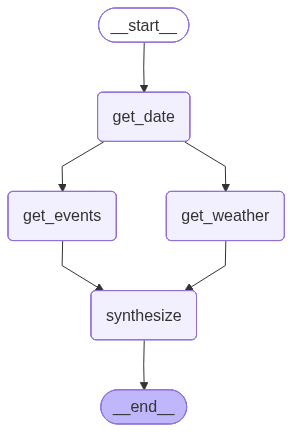

✅ Recommendation subgraph visualized

📊 2. MAIN AGENT GRAPH
--------------------------------------------------------------------------------


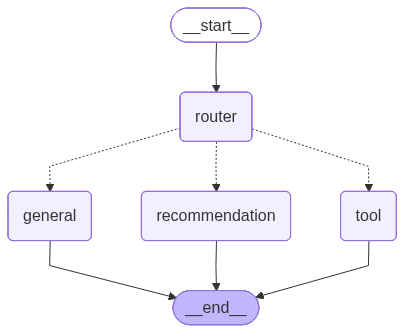

✅ Main agent graph visualized

🎯 WORKFLOW VISUALIZATION BENEFITS:
✅ See explicit execution paths
✅ Identify parallel execution opportunities
✅ Debug routing logic visually
✅ Understand state flow between nodes
✅ Documentation for team collaboration


In [16]:
# Visualize Graph Structures

print("=" * 80)
print("GRAPH VISUALIZATIONS")
print("=" * 80)
print()

print("📊 1. RECOMMENDATION SUBGRAPH")
print("-" * 80)
try:
    # Generate Mermaid diagram for recommendation graph
    rec_graph_image = compiled_recommendation_graph.get_graph().draw_mermaid_png()
    display(Image(rec_graph_image))
    print("✅ Recommendation subgraph visualized")
except Exception as e:
    print(f"⚠️ Visualization failed: {e}")
    print("Note: Mermaid visualization requires graphviz or mermaid-cli")

print()
print("📊 2. MAIN AGENT GRAPH")
print("-" * 80)
try:
    # Generate Mermaid diagram for main graph
    main_graph_image = compiled_main_graph.get_graph().draw_mermaid_png()
    display(Image(main_graph_image))
    print("✅ Main agent graph visualized")
except Exception as e:
    print(f"⚠️ Visualization failed: {e}")
    print("Note: Mermaid visualization requires graphviz or mermaid-cli")

print()
print("=" * 80)
print("🎯 WORKFLOW VISUALIZATION BENEFITS:")
print("=" * 80)
print("✅ See explicit execution paths")
print("✅ Identify parallel execution opportunities")
print("✅ Debug routing logic visually")
print("✅ Understand state flow between nodes")
print("✅ Documentation for team collaboration")

### Chat Interface

In [17]:
# Chat Interface Functions - Updated for LangGraph Migration

agent = compiled_main_graph
agent_name = "LangGraph"

# Thread configuration for conversation persistence
config = {"configurable": {"thread_id": "main_conversation"}}

def chat(user_input: str):
    """Send a message to the agent and display the response."""
    print(f"🤖 Using: {agent_name}")
    
    try:
        # Invoke agent with unified interface
        result = agent.invoke(
            {"messages": [HumanMessage(content=user_input)]},
            config=config
        )
        
        # Extract the last AI message
        if result and "messages" in result:
            messages = result["messages"]
            # Get the last assistant message (skip router messages)
            ai_messages = [msg for msg in messages if isinstance(msg, AIMessage) and msg.name != "router"]
            if ai_messages:
                output = ai_messages[-1].content
                print("AI:")
                display(Markdown(output))
                return {"output": output, "messages": messages}
            else:
                print("⚠️ No response from agent.")
                return {"output": "⚠️ No response generated.", "messages": messages}
        else:
            print("⚠️ Unexpected response format.")
            return {"output": "⚠️ Unexpected response format.", "messages": []}    
    except Exception as e:
        print(f"⚠️ Unexpected error: {e}")
        import traceback
        traceback.print_exc()
        return {"output": f"⚠️ Unexpected error occurred: {e}"}

def chat_loop():
    """Start an interactive chat session."""
    print("Chat started! Type 'quit' to exit.\\n")
    print(f"💡 Using {agent_name} agent\\n")
    print("💡 Conversation history is preserved across messages within this session.\\n")
    while True:
        try:
            user_input = input("You: ").strip()
            if user_input.lower() in ['quit', 'exit', 'q']:
                print("Goodbye!")
                break
            if not user_input:
                continue
            print(f"You: {user_input}")
            chat(user_input)
        except KeyboardInterrupt:
            print("\\n🛑 Session interrupted by user.")
            break
        except Exception as e:
            print(f"⚠️ Error during chat loop: {e}")
            continue

def reset_conversation():
    """Reset the conversation by creating a new thread."""
    global config
    import uuid
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    print("✅ Conversation history cleared. Starting fresh.")

In [19]:
# Streaming Chat Interface with Progress Indicators

def chat_with_streaming(user_input: str):
    """Send a message to LangGraph agent with real-time streaming."""
    if not USE_LANGGRAPH:
        print("⚠️ Streaming only available with LangGraph agent. Use switch_agent(True) first.")
        return chat(user_input)
    
    print(f"🤖 Using: LangGraph (Streaming Mode)")
    print()
    
    try:
        # Stream events from the graph
        last_output = None
        
        for event in compiled_main_graph.stream(
            {"messages": [HumanMessage(content=user_input)]},
            config=config,
            stream_mode="updates"  # Stream state updates
        ):
            # event is a dict with node name as key
            for node_name, node_output in event.items():
                if node_name == "router":
                    print(f"🧭 Router analyzing intent...")
                elif node_name == "recommendation":
                    print(f"📅 Running recommendation workflow...")
                    print(f"   ├─ Fetching date...")
                    print(f"   ├─ Getting weather (parallel)")
                    print(f"   ├─ Loading events (parallel)")
                    print(f"   └─ Synthesizing recommendations...")
                elif node_name == "tool":
                    print(f"🔧 Executing tools...")
                elif node_name == "general":
                    print(f"💬 Generating response...")
                
                # Store last output
                if "messages" in node_output and node_output["messages"]:
                    last_output = node_output
        
        print()
        print("✅ Processing complete")
        print()
        
        # Extract and display final response
        if last_output and "messages" in last_output:
            messages = last_output["messages"]
            ai_messages = [msg for msg in messages if isinstance(msg, AIMessage) and msg.name != "router"]
            if ai_messages:
                output = ai_messages[-1].content
                print("AI:")
                display(Markdown(output))
                return {"output": output, "messages": messages}
        
        print("⚠️ No response from agent.")
        return {"output": "⚠️ No response generated.", "messages": []}
    
    except Exception as e:
        print(f"⚠️ Unexpected error: {e}")
        import traceback
        traceback.print_exc()
        return {"output": f"⚠️ Unexpected error occurred: {e}"}

def chat_loop_streaming():
    """Start an interactive chat session with streaming."""
    print("Chat started (Streaming Mode)! Type 'quit' to exit.\\n")
    print("💡 Real-time progress indicators enabled\\n")
    while True:
        try:
            user_input = input("You: ").strip()
            if user_input.lower() in ['quit', 'exit', 'q']:
                print("Goodbye!")
                break
            if not user_input:
                continue
            print(f"You: {user_input}")
            print()
            chat_with_streaming(user_input)
            print()
        except KeyboardInterrupt:
            print("\\n🛑 Session interrupted by user.")
            break
        except Exception as e:
            print(f"⚠️ Error during chat loop: {e}")
            continue

print("✅ Streaming interface ready")
print("💡 Use chat_with_streaming(query) for real-time progress")
print("💡 Use chat_loop_streaming() for interactive streaming chat")

✅ Streaming interface ready
💡 Use chat_with_streaming(query) for real-time progress
💡 Use chat_loop_streaming() for interactive streaming chat


## Testing

In [19]:
chat_loop()

Chat started! Type 'quit' to exit.\n
💡 Using LangGraph agent\n
💡 Conversation history is preserved across messages within this session.\n


You:  quit


Goodbye!


In [23]:
chat_loop()

Chat started! Type 'quit' to exit.\n
💡 Using LangGraph agent\n
💡 Conversation history is preserved across messages within this session.\n
You: what can you do?
🤖 Using: LangGraph
🧭 Router: Classified intent as 'general'
AI:


I can help you plan events in Singapore by recommending activities based on the weather and your preferences, providing information about venue policies for Marina Bay Sands, Gardens by the Bay, and Esplanade, generating event images, and answering questions about accessibility, restrictions, and logistics. How can I assist you today?

You: can i bring food to mbs events?
🤖 Using: LangGraph
🧭 Router: Classified intent as 'venue_policy'
🔧 Executing tool: retrieve_venue_policies
AI:


[MBS-Event-Policy, p.2]
3.5 Audio-Visual Equipment
In-House Services Include:
Line array speaker systems
HD projectors (10,000 - 15,000 lumens)
Large format screens (250-300 inches)
Conference microphones
HD cameras for recording/live streaming
Simultaneous translation systems
Stage setup and carpentry works
Lighting fixtures and control
Client-Provided Equipment:
Must be submitted for approval 14 days in advance
Technical specifications and power requirements must be detailed
Installation must comply with venue safety standards
Licensed Electrical Worker (LEW) certification required for complex electrical installations
4. Catering & Food Service Policies
4.1 Approved Vendors Policy
Marina Bay Sands operates an exclusive catering policy:
In-house catering: All food and beverage services must be provided by Marina Bay Sands' approved caterers
No outside food/beverages: Pre-purchased food and beverages are prohibited from being brought into the venue

[MBS-Event-Policy, p.0]
Marina Bay Sands Event Policy Guide
Sands Expo and Convention Centre
10 Bayfront Avenue, Singapore 018956
Last Updated: November 2024
Table of Contents
1. Event Policy Overview
2. Photography & Videography Rules
3. Equipment Restrictions & Technical Specifications
4. Catering & Food Service Policies
5. Accessibility Features
6. Insurance & Liability Requirements
7. Setup & Teardown Windows
8. Safety & Security Protocols
9. Cancellation & Payment Terms
10. Contact Information
1. Event Policy Overview
1.1 Venue Capacity
Marina Bay Sands Expo & Convention Centre spans 120,000 square meters across five levels and can accommodate up to 45,000 delegates simultaneously. The
facility features:
Exhibition Halls: 6 halls (A, B, C on Level 1; D, E, F on Basement 2) totaling over 30,000 sqm
Meeting Rooms: 250 configurable spaces
Ballrooms: Including Southeast Asia's largest ballroom (Sands Grand Ballroom - 7,672 sqm)
Exhibition Booths: Capacity for up to 2,000 booths
1.2 Booking Requirements

[MBS-Event-Policy, p.7]
Important Notice: This document provides general guidelines. Specific requirements may vary based on event type, size, and complexity. Always confirm current
policies with Marina Bay Sands venue sales team at time of booking. Marina Bay Sands reserves the right to update policies without prior notice.
Disclaimer: This is an informational document compiled from publicly available information and industry standards. Event organizers should verify all requirements
directly with Marina Bay Sands prior to finalizing event plans.


You: recommend some events today
🤖 Using: LangGraph
🧭 Router: Classified intent as 'recommendation'
📍 Extracted params: location=Singapore, country=Singapore, event_type=None
📅 Date retrieved: 2025-11-04
📋 Events retrieved: 2 events found
🌤️  Weather fetched: Weather in Singapore, Singapore: 28.1°C, Partly cloudy
✅ Recommendations synthesized
AI:


With the weather in Singapore being a comfortable 28.1°C and partly cloudy, both indoor and outdoor events can be enjoyable options today.

If you enjoy the arts and music, the Singapore Jazz Night at Esplanade offers a promising indoor experience with live performances from regional jazz bands. It's an excellent choice if you prefer a more relaxed, climate-controlled environment.

On the other hand, if you're a nature enthusiast, the Singapore Botanic Fair at the Singapore Botanic Gardens is an appealing outdoor option. The partly cloudy conditions provide a pleasant backdrop for exploring the flower and plant exhibitions without the harshness of direct sunlight.

Both events have their unique appeal, so choose based on your interest in music or nature. Enjoy your day!

Goodbye!


In [24]:
chat_loop_streaming()

Chat started (Streaming Mode)! Type 'quit' to exit.\n
💡 Real-time progress indicators enabled\n
You: how many questions have i asked?

🤖 Using: LangGraph (Streaming Mode)

🧭 Router: Classified intent as 'general'
🧭 Router analyzing intent...
📍 Extracted params: location=Singapore, country=Singapore, event_type=None
📅 Date retrieved: 2025-11-04
📋 Events retrieved: 2 events found
🌤️  Weather fetched: Weather in Singapore, Singapore: 28.0°C, Partly cloudy
✅ Recommendations synthesized
📅 Running recommendation workflow...
   ├─ Fetching date...
   ├─ Getting weather (parallel)
   ├─ Loading events (parallel)
   └─ Synthesizing recommendations...

✅ Processing complete

AI:


Given the current weather in Singapore, which is 28.0°C and partly cloudy, both indoor and outdoor events can be suitable. However, since Singapore can be quite humid and warm, enjoying some shade or a cooler setting might be preferred by some.

1. **Singapore Jazz Night (indoor)** - This indoor event at the Esplanade is a great choice if you prefer to avoid the humidity and heat. You can enjoy live performances by regional jazz bands in a comfortable and climate-controlled environment.

2. **Singapore Botanic Fair (outdoor)** - If you enjoy being surrounded by nature and the weather being partly cloudy means not a lot of direct sunlight, this outdoor event could be quite pleasant. The Singapore Botanic Gardens offers beautiful scenery and fresh air, making it an ideal spot for a day out exploring flowers and plants.

Consider what type of experience you are looking for, whether it's vibrant music indoors or a peaceful stroll among nature. Both events offer unique experiences.


You: how many questions have i asked?

🤖 Using: LangGraph (Streaming Mode)

🧭 Router: Classified intent as 'general'
🧭 Router analyzing intent...
📍 Extracted params: location=Singapore, country=Singapore, event_type=None
📅 Date retrieved: 2025-11-04
📋 Events retrieved: 2 events found
🌤️  Weather fetched: Weather in Singapore, Singapore: 28.0°C, Partly cloudy
✅ Recommendations synthesized
📅 Running recommendation workflow...
   ├─ Fetching date...
   ├─ Getting weather (parallel)
   ├─ Loading events (parallel)
   └─ Synthesizing recommendations...

✅ Processing complete

AI:


With the current weather in Singapore being 28.0°C and partly cloudy, outdoor activities are quite enjoyable as the temperature is comfortable and the skies are not fully overcast. I recommend visiting the Singapore Botanic Fair at the Botanic Gardens. It's a great opportunity to appreciate the beautiful outdoor setting and enjoy the plant exhibition without being hindered by rain or excessive heat.

However, if you prefer an indoor activity or want to avoid any chance of unexpected rain, the Singapore Jazz Night at the Esplanade is an excellent alternative. You can enjoy live performances by regional jazz bands in a comfortable, climate-controlled environment. Both events offer a unique experience, so consider what vibe you are in the mood for today!


You: hi?

🤖 Using: LangGraph (Streaming Mode)

🧭 Router: Classified intent as 'general'
🧭 Router analyzing intent...
📍 Extracted params: location=Singapore, country=Singapore, event_type=None
📅 Date retrieved: 2025-11-04
📋 Events retrieved: 2 events found
🌤️  Weather fetched: Weather in Singapore, Singapore: 28.0°C, Partly cloudy
✅ Recommendations synthesized
📅 Running recommendation workflow...
   ├─ Fetching date...
   ├─ Getting weather (parallel)
   ├─ Loading events (parallel)
   └─ Synthesizing recommendations...

✅ Processing complete

AI:


With the current weather in Singapore being 28.0°C and partly cloudy, both indoor and outdoor activities are suitable. 

For a culturally enriching experience, consider attending the Singapore Jazz Night at the Esplanade. It's an indoor event featuring live performances by regional jazz bands, perfect for enjoying music while staying comfortable regardless of any unexpected weather changes.

On the other hand, if you're keen on exploring natural beauty, the Singapore Botanic Fair at the Botanic Gardens is an excellent choice. The mild temperature with the partly cloudy sky provides a pleasant setting for strolling and appreciating the floral and plant displays.

Both events offer unique experiences, but if you wish to stay flexible with the weather, the covered comfort of the jazz night is a strong option.


Goodbye!


# END